In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
# import get_full_info
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings

2024-04-02 07:29:59.011052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# df = get_full_info.df
# df.to_csv("full_info.csv", index = False)
df = pd.read_csv("full_info.csv")

# df_latest = get_full_info.df_realtime
# df_latest.to_csv("latest_years.csv", index = False)
df_latest = pd.read_csv("latest_years.csv")

In [3]:
df

,year,state,average_annual_rent,place,rent_growth_last_1_years,rent_growth_last_2_years,rent_growth_last_3_years,average_home_value,home_val_growth_last_1_years,home_val_growth_last_2_years,...,female_67_to_69_years,female_70_to_74_years,female_75_to_79_years,female_80_to_84_years,female_85_years_and_over,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years,roi
0,2009,Alabama,8408.16,Baldwin County - Alabama,0.000000,0.042994,0.075123,231420.95,0.000000,0.038236,...,0.014361,0.022797,0.018064,0.013093,0.010744,0.312590,0.000000,-0.005244,-0.003565,-0.0062
1,2009,Alabama,4875.60,Calhoun County - Alabama,0.000000,0.042994,0.075123,122337.14,0.000000,0.038236,...,0.011968,0.021289,0.017235,0.015420,0.011835,0.121506,0.000000,-0.005244,-0.003565,0.2437
2,2009,Alabama,4729.56,Cullman County - Alabama,0.000000,0.042994,0.075123,136905.20,0.000000,0.038236,...,0.014015,0.019162,0.018926,0.012613,0.011782,0.154260,0.000000,-0.005244,-0.003565,0.1810
3,2009,Alabama,4656.72,Etowah County - Alabama,0.000000,0.042994,0.075123,122375.53,0.000000,0.038236,...,0.016355,0.018992,0.018080,0.016898,0.014891,0.116284,0.000000,-0.005244,-0.003565,0.1432
4,2009,Alabama,5366.88,Houston County - Alabama,0.000000,0.042994,0.075123,142243.42,0.000000,0.038236,...,0.012833,0.020043,0.017046,0.012998,0.015202,0.147156,0.000000,-0.005244,-0.003565,0.1967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079,2019,Puerto Rico,5562.84,Bayamón Municipio - Puerto Rico,0.025008,-0.015001,0.058186,135117.94,-0.068198,-0.061326,...,0.021315,0.029864,0.027731,0.025197,0.017026,0.174347,-0.195640,-0.229151,0.093312,0.2981
7080,2019,Puerto Rico,5208.24,Caguas Municipio - Puerto Rico,-0.161346,-0.049432,-0.149681,155403.81,-0.022772,0.091344,...,0.019718,0.027607,0.029204,0.020264,0.012078,0.170325,0.043777,-0.072503,0.050426,0.2272
7081,2019,Puerto Rico,7029.72,Carolina Municipio - Puerto Rico,0.111953,0.058489,0.136083,154010.53,-0.041466,-0.025863,...,0.018744,0.032670,0.025792,0.021445,0.023880,0.227712,0.142933,0.363009,0.236695,0.3470
7082,2019,Puerto Rico,4375.32,Ponce Municipio - Puerto Rico,0.081287,0.124281,0.096341,118080.87,-0.059668,0.042913,...,0.022983,0.030292,0.030922,0.014339,0.016689,0.199670,0.100366,-0.093855,-0.076870,0.0759


In [4]:
df_opzones = pd.read_csv("opzone_list.csv")

In [5]:
# df_opzones

In [6]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [7]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [8]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [9]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in df_latest['place'] if any(y in x for y in opzones)]
df_latest = df_latest[df_latest['place'].isin(opzones_formatted)]

In [10]:
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  361946.5698018018
median current value:  302245.34
25th percentile current value:  236493.785
number 200k or less:  70


In [11]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                                                                        # '3' not in x and\
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,average_annual_rent,place,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
4295,2022,10077.00,Webb County - Texas,214876.97,267780,0.066400,-0.274451,-0.312893,-0.398654
4177,2022,9995.76,Summit County - Ohio,243907.40,535882,0.067572,-0.057368,-0.144442,-0.237275
4172,2022,9986.76,Montgomery County - Ohio,208866.70,533892,0.068186,-0.320557,-0.375939,-0.425148
3954,2022,9650.40,Black Hawk County - Iowa,214102.22,130274,0.071951,-0.130795,-0.139619,-0.361561
4218,2022,8984.28,Erie County - Pennsylvania,206149.49,267689,0.073566,-0.059963,-0.202974,-0.235928
3930,2022,9316.92,Madison County - Illinois,230026.84,263864,0.076456,-0.003611,-0.185406,-0.231434
3942,2022,8528.40,Delaware County - Indiana,160351.62,112031,0.080454,-0.258178,-0.298912,-0.400547
4019,2022,9311.88,Jackson County - Michigan,218947.34,160066,0.086192,-0.179692,-0.199089,-0.284876
3975,2022,10338.12,Bossier Parish - Louisiana,243277.00,129276,0.097280,-0.176416,-0.295024,-0.338428
4296,2022,9778.08,Wichita County - Texas,184143.64,129978,0.099112,-0.161077,-0.261678,-0.293045


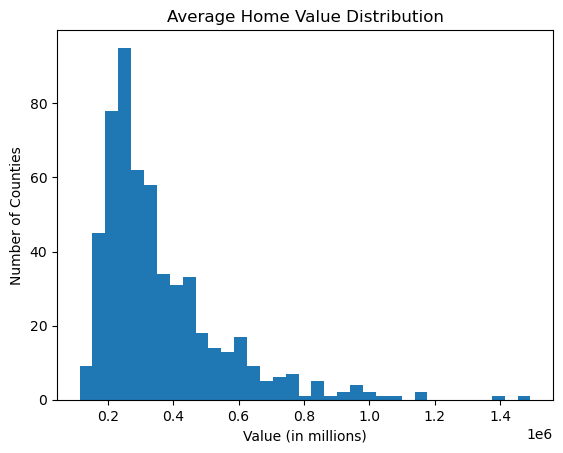

In [12]:
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")
plt.savefig("Home_Values_Dist")

In [13]:
df_latest['vacancy_rate'].mean()

0.09232452947995137

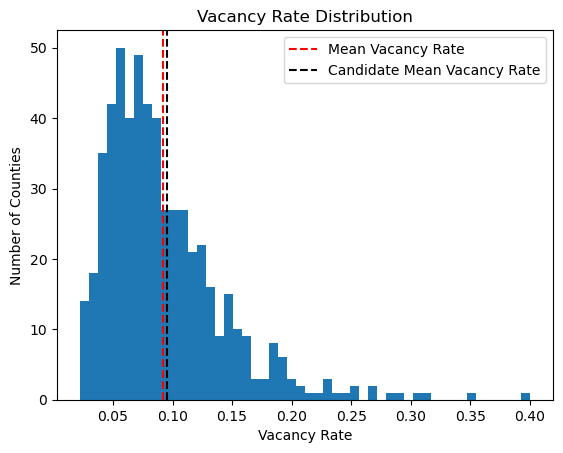

In [14]:
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")
plt.savefig("Vacancy_Dist")

In [15]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.09232452947995137
median current vacancy rate:  0.0802365539838567
25th percentile current vacancy rate:  0.05640196145241215


(array([ 7.,  6., 11.,  6., 17., 14., 16., 21., 25., 20., 22., 19., 23.,
        16., 25., 16., 25., 21., 14., 13., 12., 20.,  7., 13., 11., 17.,
         9.,  8.,  6., 14.,  6.,  9.,  3.,  5.,  9.,  7.,  4.,  6.,  2.,
         5.,  3.,  2.,  1.,  2.,  2.,  4.,  3.,  3.,  3.,  3.]),
 array([0.02199413, 0.02553192, 0.0290697 , 0.03260749, 0.03614527,
        0.03968305, 0.04322084, 0.04675862, 0.05029641, 0.05383419,
        0.05737197, 0.06090976, 0.06444754, 0.06798533, 0.07152311,
        0.07506089, 0.07859868, 0.08213646, 0.08567425, 0.08921203,
        0.09274981, 0.0962876 , 0.09982538, 0.10336317, 0.10690095,
        0.11043873, 0.11397652, 0.1175143 , 0.12105209, 0.12458987,
        0.12812765, 0.13166544, 0.13520322, 0.13874101, 0.14227879,
        0.14581657, 0.14935436, 0.15289214, 0.15642993, 0.15996771,
        0.16350549, 0.16704328, 0.17058106, 0.17411885, 0.17765663,
        0.18119441, 0.1847322 , 0.18826998, 0.19180777, 0.19534555,
        0.19888333]),
 <BarContainer

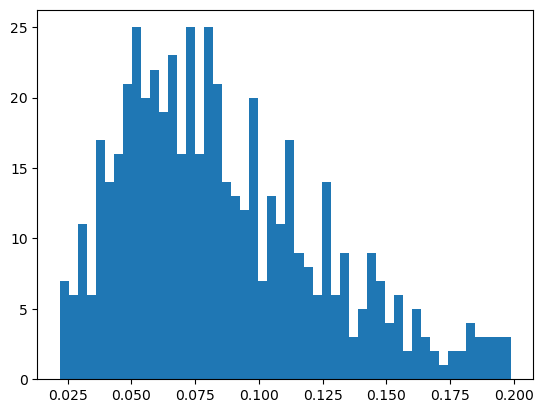

In [16]:
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [17]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [18]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4209
validation sample -  578
test sample -  523


In [19]:
# SCALE NON-PERCENTAGES
std_scl = StandardScaler()

In [20]:
#X, Y SPLITS
ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

LET'S SET SOME "DUMB" BASELINES; A VERY SIMPLE MODEL AND STANDARD DEV (THIS ONE SHOULD BE HARDER SINCE WE DON'T KNOW AVERAGE OF POPULATION BEFOREHAND)

In [21]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [22]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3207628027681661
actuals standard dev -  0.10560311174465994


In [23]:
vali['average_home_value'] = vali['average_home_value'].astype('float')
vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
vali['average_annual_rent'] = vali['average_annual_rent'].astype('float')
vali['rent_growth_last_1_years'] = vali['rent_growth_last_1_years'].astype('float')
vali['rent_growth_last_2_years'] = vali['rent_growth_last_2_years'].astype('float')
vali['rent_growth_last_3_years'] = vali['rent_growth_last_3_years'].astype('float')


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/939463968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['average_home_value'] = vali['average_home_value'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/939463968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/939463968.py:3: SettingWithCo

In [24]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [25]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  0.14113251644193067
mae -  0.10913875432525952


START W/ OUT OF THE BOX PREDICTIONS

In [26]:
lr = lm.LinearRegression()
# TRAIN/VALI
lr_preds = lr.fit(ex_train_scaled, why_train).predict(ex_vali_scaled)
print('rmse - ', m.sqrt(mse(why_vali, lr_preds)))
print('mae - ', mae(why_vali, lr_preds))
print('r sq - ', lr.fit(ex_train_scaled, why_train).score(ex_vali_scaled, why_vali))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
lr_train_preds = lr.fit(ex_train_scaled, why_train).predict(ex_train_scaled)
print('training rmse - ', m.sqrt(mse(why_train, lr_train_preds)))
print('training mae - ', mae(why_train, lr_train_preds))
print('training r sq - ', lr.fit(ex_train_scaled, why_train).score(ex_train_scaled, why_train))

rmse -  124722048649.44276
mae -  94555944492.14798
r sq -  -1.397285222281957e+24
training rmse -  0.10493969548353313
training mae -  0.07345168147055402
training r sq -  0.5320192160922603


In [27]:
rf = ens.RandomForestRegressor()
# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# # PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.12793190086669856
mae -  0.09827957093425606
training rmse -  0.0321936174386725
training mae -  0.02299977999524828


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/3620537912.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

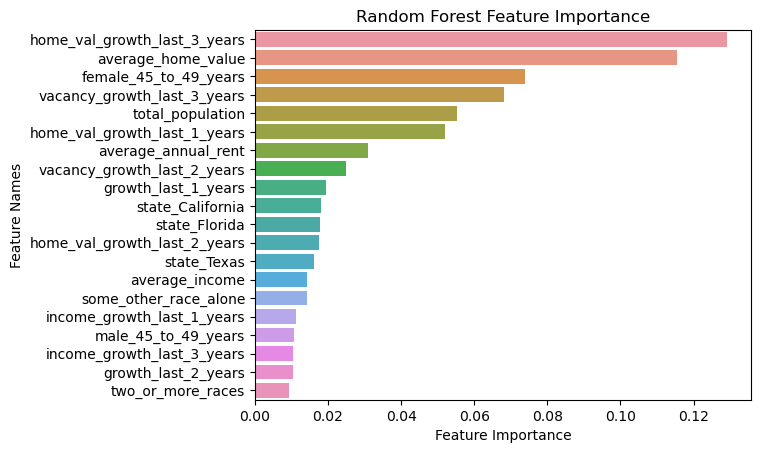

In [28]:
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

VERSUS HYPERPARAMATER TUNED

In [29]:
%store -r rf_params

In [30]:
rf_params

{'rf__n_estimators': 50,
 'rf__max_depth': 30,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 18}

In [31]:
steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
         ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                      max_depth = rf_params['rf__max_depth'],
                                      criterion = rf_params['rf__criterion']))]
model_rf = Pipeline(steps = steps)

# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.15241361015820262
mae -  0.1181636105738
training rmse -  0.046147155125338166
training mae -  0.03342505561499888


In [32]:
%store -r ada_params

In [33]:
ada_params

{'n_estimators': 150, 'learning_rate': 1}

In [34]:
ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], learning_rate = ada_params['learning_rate'])
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.12922214425710224
mae -  0.09835494776093634
training rmse -  0.10425661905201308
training mae -  0.08353234323758629


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/3200975213.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

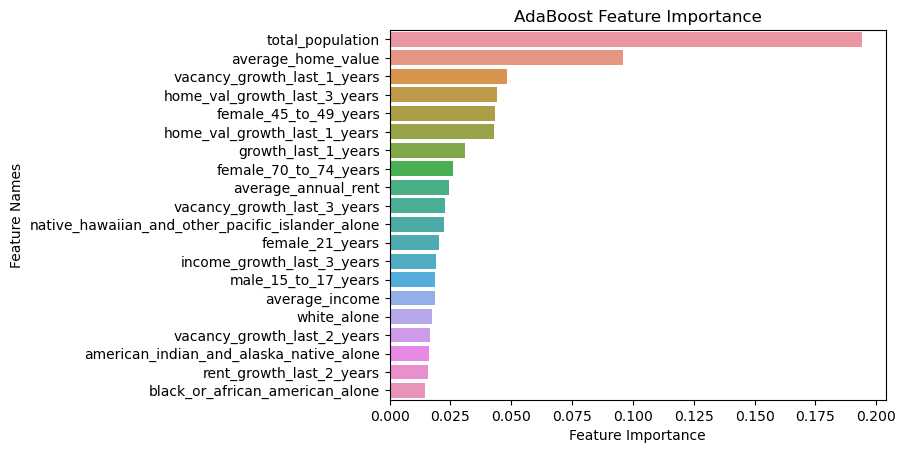

In [35]:
feature_names = ex_train.columns
importances = ada_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
ada_df = pd.DataFrame(data)
ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
ada_df = ada_df.head(20)

sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('AdaBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [36]:
%store -r xgboost_params

In [37]:
xgboost_params

{'scale_pos_weight': 1, 'max_depth': 7, 'eta': 0.1}

In [38]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)


xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                  max_depth = xgboost_params['max_depth'], 
                  eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.1276655052827606
mae -  0.0987544901237562
training rmse -  0.02920138160346676
training mae -  0.02210653317178532


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85498/1849121513.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

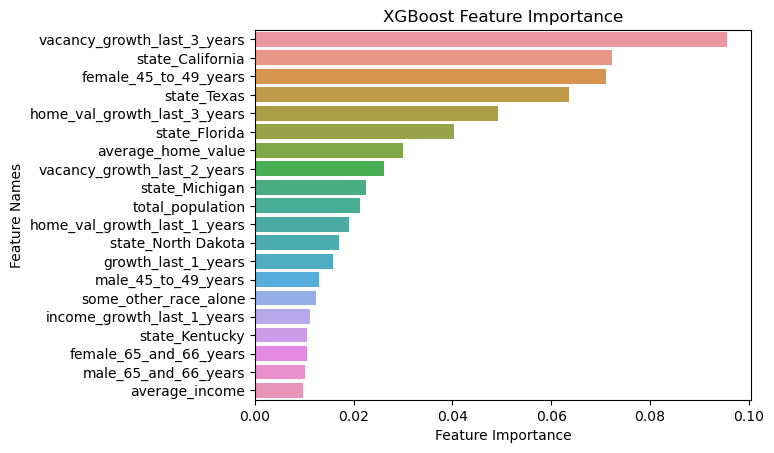

In [39]:
feature_names = ex_train.columns
importances = xg_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
xg_df = pd.DataFrame(data)
xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
xg_df = xg_df.head(20)

sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [40]:
# SO MODEL PERFORMANCE NOT GREAT, BUT I WANNA SEE WHAT THE TOP PREDICTED AREAS WERE FOR FUN
# AFTER ALL, IF IT'S TYPICALLY OFF BUT THE VERY HIGH PREDS ARE MORE SOLID, THEN THIS ACTUALLY IS STILL USEFUL
# SINCE OUR GOAL IS TO USE THIS TO IDENTIFY TOP CANDIDATES
# RF WAS MOST PERFORMANT SO GOING TO BASE THIS ON THOSE PREDS

vali['predicted_roi'] = rf_preds

In [41]:
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [42]:
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

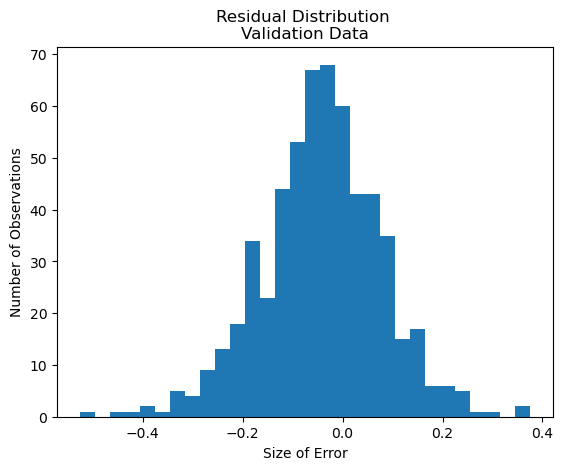

In [43]:
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")
plt.savefig("Model_Residuals")

In [44]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in pred_check['place'] if any(y in x for y in opzones)]
pred_check = pred_check[pred_check['place'].isin(opzones_formatted)]

In [45]:
print('actuals mean - ', why_vali.mean())

actuals mean -  0.3207628027681661


In [46]:
pred_check[~pred_check['place'].str.contains('California')].head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6526,2018,16922.16,Snohomish County - Washington,506140.29,814901,0.3930,0.488798
6519,2018,14976.84,Clark County - Washington,395311.91,481857,0.4060,0.477932
6078,2018,13702.44,Manatee County - Florida,308108.90,394855,0.3612,0.469327
6403,2018,15544.08,Washington County - Oregon,457766.69,597695,0.2991,0.466355
6300,2018,17316.12,Kings County - New York,888512.14,2582830,0.0886,0.464671
6528,2018,13922.76,Thurston County - Washington,354053.10,286419,0.3786,0.464287
6074,2018,13158.84,Hillsborough County - Florida,289578.33,1436888,0.4158,0.461362
6264,2018,12342.72,Clark County - Nevada,333128.50,2231647,0.3857,0.460792
6265,2018,12799.80,Washoe County - Nevada,429330.28,465735,0.3817,0.459737
6498,2018,15253.32,Travis County - Texas,451721.79,1248743,0.3409,0.453902


In [47]:
# NOTE TO SELF - MADE LITTLE DIFFERENCE LIMITING TO COUNTIES W/OPZONES; SEEMS LIKE CENSUS IS REALLY THE FACTOR
pred_check[~pred_check['place'].str.contains('California')].sort_values(by = 'roi', ascending = False).head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6111,2018,8761.68,Canyon County - Idaho,227374.39,223499,0.8293,0.302980
6094,2018,9575.40,Clayton County - Georgia,135140.46,289615,0.7434,0.309121
6259,2018,9910.56,Missoula County - Montana,333839.85,118791,0.6949,0.289725
6109,2018,11600.04,Ada County - Idaho,340598.30,469966,0.6685,0.335066
6518,2018,11050.32,Clallam County - Washington,308602.33,76737,0.6463,0.303050
6504,2018,10380.48,Weber County - Utah,275991.40,256359,0.6456,0.385347
6073,2018,10872.96,Hernando County - Florida,172689.38,190865,0.6291,0.370684
6112,2018,11489.88,Kootenai County - Idaho,342809.76,161505,0.6086,0.419950
6052,2018,10084.80,Mesa County - Colorado,273871.14,153207,0.6059,0.150584
6509,2018,9790.44,Rockingham County - Virginia,247505.57,81244,0.5910,0.263121


In [48]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

['Pinal County - Arizona']

In [49]:
ex_total = pd.concat([pd.concat([ex_train, ex_vali]), ex_test])
why_total = pd.concat([pd.concat([why_train, why_vali]), why_test])

In [50]:
len(ex_total)

5310

In [51]:
df_latest = df_latest.dropna()
ex_serving = df_latest.drop(columns = ['year', 'place'])
ex_serving_scaled = std_scl.fit_transform(ex_serving)

In [52]:
rf_serve = rf.fit(ex_total, why_total)
rf_preds = rf_serve.predict(ex_serving)

In [53]:
df_latest['pred'] = rf_preds

In [54]:
df_latest.to_csv("latest_yrs_w_preds_county.csv")

In [55]:
model_candidates = df_latest.sort_values(by = 'pred', ascending = False)
model_candidates = model_candidates.drop(columns = [x for x in model_candidates.columns if 'state' in x or\
                                                   '1' in x or '2' in x in x or '4' in x or '5' in x or '6' in x or\
                                                   '7' in x or '8' in x or '9' in x or '0' in x or 'race' in x or\
                                                   'alone' in x or 'rent' in x or 'pop' in x or 'income' in x or 'val_growth' in x])
model_candidates[model_candidates['place'].str.contains('St. Louis')]

,year,place,average_home_value,growth_last_3_years,vacancy_rate,vacancy_growth_last_3_years,pred
4041,2022,St. Louis County - Minnesota,258975.98,0.002321,0.162341,-0.094096,0.386294
4060,2022,St. Louis County - Missouri,346733.05,-0.003813,0.073186,0.030732,0.351668
4061,2022,St. Louis city - Missouri,243902.37,-0.046571,0.147665,-0.144514,0.313852


In [56]:
model_candidates = df_latest.sort_values(by = 'pred', ascending = False)
model_candidates = model_candidates.drop(columns = [x for x in model_candidates.columns if 'state' in x or\
                                                   '1' in x or '2' in x in x or '4' in x or '5' in x or '6' in x or\
                                                   '7' in x or '8' in x or '9' in x or '0' in x or 'race' in x or\
                                                   'alone' in x or 'rent' in x or 'pop' in x or 'income' in x or 'val_growth' in x])
model_candidates = model_candidates[~model_candidates['place'].str.contains('California')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('New York')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('Hawaii')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('Puerto Rico')]
model_candidates = model_candidates[model_candidates['average_home_value'] <= 250000]
model_candidates = model_candidates[model_candidates['pred'] > df_latest['pred'].mean()]
model_candidates

,year,place,average_home_value,growth_last_3_years,vacancy_rate,vacancy_growth_last_3_years,pred
3883,2022,Highlands County - Florida,224342.18,-0.005677,0.185779,-0.183447,0.493384
3798,2022,Lauderdale County - Alabama,245995.70,0.033959,0.131206,-0.126899,0.484447
4088,2022,Doña Ana County - New Mexico,241051.49,0.023566,0.075166,-0.378052,0.463304
4132,2022,Davidson County - North Carolina,249206.87,0.029694,0.097878,0.216035,0.438047
4282,2022,Hidalgo County - Texas,163782.40,0.022631,0.121613,-0.095473,0.434151
3987,2022,Aroostook County - Maine,171387.33,0.002983,0.186160,-0.242900,0.432084
3801,2022,Marshall County - Alabama,238926.16,0.027373,0.123447,-0.078936,0.431746
3940,2022,Allen County - Indiana,236483.98,0.032033,0.062219,-0.306790,0.427052
4142,2022,Nash County - North Carolina,218186.26,0.015812,0.128926,-0.029030,0.426286
4292,2022,Taylor County - Texas,231852.60,0.051647,0.134622,0.016469,0.425378


In [57]:
df_latest_candidates['place'].values.tolist()

['Delaware County - Indiana',
 'Calhoun County - Alabama',
 'Wichita County - Texas',
 'Jefferson County - Texas',
 'Comanche County - Oklahoma',
 'Erie County - Pennsylvania',
 'San Juan County - New Mexico',
 'Montgomery County - Ohio',
 'Black Hawk County - Iowa',
 'Webb County - Texas',
 'Jackson County - Michigan',
 'Madison County - Illinois',
 'Champaign County - Illinois',
 'Bossier Parish - Louisiana',
 'Summit County - Ohio']

In [58]:
model_candidates[model_candidates['place'].isin(df_latest_candidates['place'].values.tolist())]

,year,place,average_home_value,growth_last_3_years,vacancy_rate,vacancy_growth_last_3_years,pred
4019,2022,Jackson County - Michigan,218947.34,0.009816,0.086192,-0.284876,0.423297
4184,2022,Comanche County - Oklahoma,197001.89,0.019023,0.127780,-0.327251,0.418278


In [59]:
df_latest['pred'].mean()

0.37935558918918916